In [3]:
import pandas as pd
import os
import pandas as pd
from GrBinaryIPF import GrBinaryIPF
import math
import matplotlib.pyplot as plt
import numpy as np

fpath =  "data/GermanCredit_new.csv"

In [4]:
data = pd.read_csv(fpath)

In [5]:
data.head()

,id,DurationMonth,CreditAmount,score,sex,age35,protected
0,0,0.029412,0.949433,0.600715,1,0,2
1,1,0.647059,0.686310,0.496131,0,1,3
2,2,0.117647,0.898426,0.506866,1,0,2
3,3,0.558824,0.580059,0.599482,1,0,2
4,4,0.294118,0.745791,0.550060,1,0,2


In [6]:
rank = np.argsort(data["score"])

In [7]:
group = data["protected"]

In [8]:
set(group)

{1, 2, 3, 4}

In [9]:
itemList = set(rank)

In [10]:
G1 = []
G2 = []
G3 = []
G4 = []
for i in range(0,len(itemList)):
    if(group[i] == 1):
        G1.append(group[i])
    elif(group[i] == 2):
        G2.append(group[i])
    elif(group[i] == 3):
        G3.append(group[i])
    else:
        G4.append(group[i])

In [11]:
p1 = len(G1)/len(itemList)
p2 = len(G2)/len(itemList)
p3 = len(G3)/len(itemList)
p4 = len(G4)/len(itemList)

In [12]:
A = ['1','2','3','4']

In [13]:
P = {'1':p1,'2':p2,'3':p3,'4':p4}

In [14]:
S={}
for a in A:
   
    scoreList = []
    
    S[a] = scoreList

In [15]:
score = len(rank)
for i in rank:
    if group[i] == 1:
        S[A[0]].append((score,i))
    if group[i] == 2:
        S[A[1]].append((score,i))
    if group[i] == 3:
        S[A[2]].append((score,i))
    else:
        S[A[3]].append((score,i)) 
    score = score - 1

In [16]:
def swap(dict,i,j):
    item = dict[i]
    dict[i] = dict[j]
    dict[j] = item 

In [17]:
def DetConstSort(S,A,P,kmax):
    counts = {}
    minCounts = {}
    for ai in A:
        counts[ai] = 0
        minCounts[ai] = 0
    
    rankedAttList = {}
    rankedScoreList = {}
    maxIndices = {}
    lastEmpty = 0
    k = 0
    
    while lastEmpty <= kmax:
        k = k + 1
        tempMinCounts = {}
        for ai in A:
            tempMinCounts[ai] = math.floor(k * P[ai])
        changedMins = []
        for ai in A:
            if minCounts[ai ] < tempMinCounts[ai]:
                #print(ai,counts[ai])
                changedMins.append((S[ai][counts[ai]],ai))
        if len(changedMins) != 0 :
            changedMins.sort(reverse=True)
            #ordChangedMins = changedMins
        for sai,ai in  changedMins:
            rankedAttList[lastEmpty] = ai
            
            rankedScoreList[lastEmpty] = S[ai][counts[ai]]
            maxIndices[lastEmpty] = k
            start = lastEmpty
            while start > 0 and maxIndices[start - 1] >= start and rankedScoreList[start-1][0] < rankedScoreList[start][0]:
                swap(maxIndices,start - 1,start)
                swap(rankedAttList,start - 1, start)
                swap(rankedScoreList,start - 1, start)
                start = start - 1
            counts[ai] = counts[ai] + 1 
            lastEmpty = lastEmpty + 1
        minCounts = tempMinCounts
    return (rankedAttList, rankedScoreList)

In [18]:
kmax = len(rank) - 1
rankedAttList,rankedScoreList = DetConstSort(S,A,P,kmax)

In [19]:
detOut = []
for key in rankedScoreList.keys():
    detOut.append(rankedScoreList[key][1])

In [20]:
P = {'1':p1,'2':p2,'3':p3,'4':p4}

In [21]:
P

{'1': 0.335, '2': 0.355, '3': 0.213, '4': 0.097}

In [22]:

def ApproxMultiValuedIPF(rank,group):
    rankGrp = {}
    for i in range(0,len(rank)):
        rankGrp[rank[i]] = group[i]

    grpCount = {}
    for i in group:
        grpCount[i] = 0

    rankGrpPos = {}
    for i in rank:
        grpCount[rankGrp[i]] = grpCount[rankGrp[i]] + 1
        rankGrpPos[i] = grpCount[rankGrp[i]]
    numberOfItem = len(rank)
    rankRange = {}
    for item in rank:
        i = rankGrpPos[item]
        n = numberOfItem
        fp = grpCount[rankGrp[item]]
        r1 = math.floor(i*n/fp)
        r2 = math.ceil((i+1)*n/fp) - 1
        if r2 > numberOfItem:
            r2 = numberOfItem
        rankRange[item] = (r1,r2)


    B = nx.Graph()
    top_nodes = []
    bottom_nodes = []

    for i in rank:
        top_nodes.append(i)
        bottom_nodes.append(str(i))
    B.add_nodes_from(top_nodes, bipartite=0)
    B.add_nodes_from(bottom_nodes, bipartite=1)

    for i in rank:
        r1,r2 = rankRange[i]
        #print(r1,r2)
        for j in range(1,numberOfItem+1):
            if j >= r1 and j <= r2:
                print(i,j)
                B.add_edge(i, str(j), weight = abs(i-j))
            else:
                B.add_edge(i, str(j), weight=1000000000)
                print(i,j)

    my_matching = nx.algorithms.bipartite.minimum_weight_full_matching(B, top_nodes, "weight")

In [23]:
P = {'1':p1,'2':p2,'3':p3,'4':p4}

In [24]:
posCheck = [10,25,50,100,500,1000]
z_det = []
y_out = [100 for i in range(len(rank))]
sumFail = 0
count = {'1':0,'2':0,'3':0,'4':0}
x_detConst = []
y = []
A = ['1','2','3','4']
totalViolates = 0
itrCount = 0
sumtfail = 0

for i in detOut:
    itrCount = itrCount + 1
    itemGrp = group[i]
    count[str(itemGrp)] = count[str(itemGrp)] + 1
    
    violates = False
    tViolates = 0
    for j in A:
        bot = math.floor(itrCount*P[j])
        top = math.ceil(itrCount*P[j])
        #print(j,bot,top)
        if (count[j] > top):
            violates = True
            tViolates = tViolates + 1
            
    if violates == True:
        totalViolates = totalViolates + 1
    sumtfail = sumtfail + 4 - tViolates
    z_det.append((sumtfail/itrCount)/4*100)
    #print(n,totalViolates)
#     itrCount = itrCount + 1
#     x_detConst.append((itrCount-totalViolates)/itrCount*100)
#     print('group satisfied by DetConstSort = ',itrCount,(itrCount-totalViolates)/itrCount*100)

In [37]:
res = pd.read_csv("Fig_3b_result.csv")
res.head()

,0,1,2,3,4,5,6
0,1000,800,600,500,400,200,100
1,46843,28556,16853,12043,8299,2350,700
2,42456,23203,14523,10231,7236,1536,501


In [47]:
x = list(res.iloc[0, :])
y = list(res.iloc[1, :])
z = list(res.iloc[2, :])


In [48]:
# sumFail = 0
# sumtfail = 0
# count = {0:0,1:0}
# y_det = []
# z_det = []
# A = [0,1]
# P=[  0.59, 0.067] 
# for i in range(0,len(rank)):
#     itemId = detOut[i]
#     itemGrp = group[itemId]
    
#     count[itemGrp] = count[itemGrp] + 1
    
#     violates = 0
#     tViolates = 0
#     n = i + 1
#     for j in A:
#         bot = math.floor(n*P[j])
#         top = math.ceil(n*P[j])
#         #print(j,bot,top,count[j])
#         if ((count[j] <= top ) == False ):
#             violates =  1
#             tViolates = tViolates + 1
#             #print('----------------------',j,bot,top,count[j])
#     print(n,violates)
    
#     sumFail = sumFail +  violates
#     sumtfail = sumtfail + 2 - tViolates
    
#     y_det.append(100-sumFail/n*100)
#     z_det.append((sumtfail/n)/2*100)
    
#     print('sumfail = ',n,100-sumFail/n*100)
#     print('fail group = ',n,tViolates)

In [49]:
def KendallTau(P,Q,allids):
    combinations = [p for p in itertools.product(allids, repeat=2)]
    distance = 0
    for tup in combinations:
        if P[tup[0]] < P[tup[1]] and  Q[tup[1]] < Q[tup[0]]:
            distance = distance + 1
    return distance
P={}
Q = {}
import itertools
allids = []
for i in range(0,len(detOut)):
    allids.append(i)
    
for i in range(0, len(detOut)):
    P[detOut[i]] = i
    Q[rank[i]] = i


In [50]:
Rout = []

In [51]:
# sumFail = 0
# count = {'1':0,'2':0,'3':0,'4':0}
# x_detConst = []
# y = []
# A = ['1','2','3','4']
# totalViolates = 0
# for i in Rout:
#     itemGrp = group[i]
#     count[str(itemGrp)] = count[str(itemGrp)] + 1
    
#     violates = False
#     n = i + 1
#     for j in A:
#         bot = math.floor(n*P[j])
#         top = math.ceil(n*P[j])
#         #print(j,bot,top)
#         if (count[j] > top ):
#             violates = True
#     if violates == True:
#         totalViolates = totalViolates + 1
#     #print(n,totalViolates)
    
#     x_detConst.append((n-totalViolates)/n*100)
#     print('pfairness satisfied by ApproxMultiValuedIPF = ',n,(n-totalViolates)/n*100)

In [52]:
# P={}
# Q = {}
# #Rout.append(8)
# import itertools
# allids = []
# for i in range(0,len(Rout)):
#     allids.append(i)
    
# for i in range(0, len(Rout)):
#     P[Rout[i]] = i
#     Q[rank[i]] = i

# KendallTau(P,Q,allids)

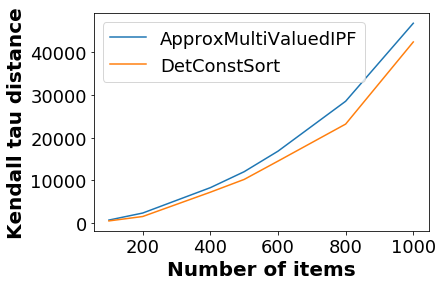

In [53]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(x,y)
plt.plot(x,z)
# create an index for each tick position

plt.ylabel('Kendall tau distance',fontweight='bold',fontsize=20)
plt.xlabel('Number of items',fontweight='bold',fontsize=20)

#plt.xticks([100,20,30,40,50], ['10','20','30','40','50'])
#plt.yticks([1000,2000,3000,4000], ['1000','2000','3000',''])
plt.legend(["ApproxMultiValuedIPF","DetConstSort"],fontsize=18,loc='upper left')
#fig.savefig("newfig/fig_3/new/ApproxMultiValuedIPF_vs_detConstSort_german_kendalTau.png", bbox_inches='tight', dpi=480)
plt.show()